In [1]:
# import required libraries
import cv2
import numpy as np
from google.colab.patches import cv2_imshow

from matplotlib import pyplot as plt

import os
import numpy as np
import torch
import glob
import torch.nn as nn
from torchvision.transforms import transforms
from torch.utils.data import DataLoader
from torch.optim import Adam
from torch.autograd import Variable
import torchvision
import pathlib

from PIL import Image
from io import open
import torch.functional as F
from torchvision.models import squeezenet1_1
import time

**FIRST STEP:** Detect if it's a propane gas cylinder or not. Difference bigger than 25% would stop the code.

In [ ]:
# load the input images
img1 = cv2.imread('/content/prueba21.jpg')
img2 = cv2.imread('/content/galonGasolina.jpg')

img1 = cv2.resize(img1,(480,480))
img2 = cv2.resize(img2,(480,480))

# convert the images to grayscale
img1 = cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY)
img2 = cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY)

# define the function to compute MSE between two images
def mse(img1, img2):
   h, w = img1.shape
   diff = cv2.subtract(img1, img2)
   err = np.sum(diff**2)
   mse = err/(float(h*w))
   return mse, diff

error, diff = mse(img1, img2)
print("Image matching Error between the two images:",error)

#cv2_imshow(diff)
position = (5,30)
text = "Difference = " + str(int(error)) +"%"
cv2.putText(
     diff, #numpy array on which text is written
     text, #text
     position, #position at which writing has to start
     cv2.FONT_HERSHEY_SIMPLEX, #font family
     1, #font size
     (209, 80, 0, 255), #font color
     3) #font stroke
cv2.imwrite('output.png', diff)

cv2_imshow(cv2.imread('output.png'))
if error > 25:
    print("No cylinder detected")
    os._exit(0)


Image matching Error between the two images: 40.07815538194444


**SECOND STEP:** Classifying if it is a big or small cylinder.

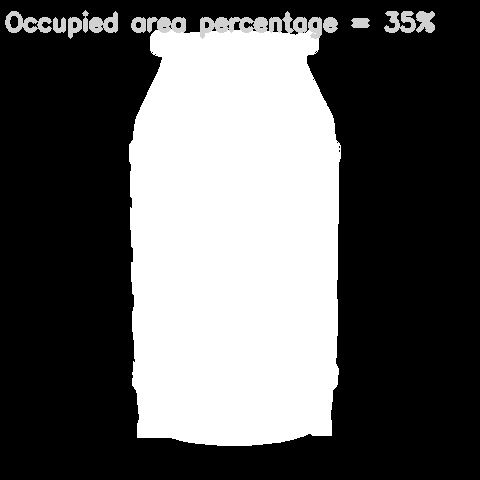

It's a small cylinder


In [13]:
img = cv2.imread('/content/prueba21.jpg')

mask = np.zeros(img.shape[:2],np.uint8)

bgdModel = np.zeros((1,65),np.float64)
fgdModel = np.zeros((1,65),np.float64)

rect = (129,24,338,443)

#applying grabcut
cv2.grabCut(img,mask,rect,bgdModel,fgdModel,5,cv2.GC_INIT_WITH_RECT)
mask2 = np.where((mask==2)|(mask==0),0,1).astype('uint8')
img = img*mask2[:,:,np.newaxis]

#thresholding
cvimg = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
ret,thresh = cv2.threshold(cvimg,0,255,cv2.THRESH_BINARY)

count = cv2.countNonZero(thresh)

#print("White " , count)

resized_image = cv2.resize(thresh, (480,480))
#cv2_imshow(resized_image)
#plt.imshow(img)
#plt.colorbar()
#plt.show()
(height, width, _) = img.shape
percentage =( count/(height*width) )*100
#print("percentage",percentage)

position = (5,30)
text = "Occupied area percentage = " + str(int(percentage)) +"%"
cv2.putText(
     resized_image, #numpy array on which text is written
     text, #text
     position, #position at which writing has to start
     cv2.FONT_HERSHEY_SIMPLEX, #font family
     0.8, #font size
     (209, 80, 0, 255), #font color
     3) #font stroke
cv2.imwrite('output.png', resized_image)

cv2_imshow(cv2.imread('output.png'))

cv2.waitKey(0)
cv2.destroyAllWindows()

if percentage > 50:
  print("It's a big cylinder")
else:
  print("It's a small cylinder")

**THIRD STEP:** Recognizing if it's a composite or steel cylinder.

In [4]:
#CNN Network

class ConvNet(nn.Module):
    def __init__(self,num_classes=2):
        super(ConvNet,self).__init__()
        
        #Output size after convolution filter
        #((w-f+2P)/s) +1
        
        #Input shape= (32,3,224,224)
        
        self.conv1=nn.Conv2d(in_channels=3,out_channels=12,kernel_size=3,stride=1,padding=1)
        #Shape= (32,12,224,224)
        self.bn1=nn.BatchNorm2d(num_features=12)
        self.relu1=nn.ReLU()

        
        self.pool=nn.MaxPool2d(kernel_size=2)
        #Reduce the image size be factor 2
        #Shape= (32,12,112,112)
        
        
        self.conv2=nn.Conv2d(in_channels=12,out_channels=20,kernel_size=3,stride=1,padding=1)
        #Shape= (32,20,112,112)
        self.bn2=nn.BatchNorm2d(num_features=20)
        self.relu2=nn.ReLU()
        

        self.conv3=nn.Conv2d(in_channels=20,out_channels=32,kernel_size=3,stride=1,padding=1)
        #Shape= (32,32,112,112)
        self.bn3=nn.BatchNorm2d(num_features=32)
        self.relu3=nn.ReLU()
        
        
        self.fc=nn.Linear(in_features= 112 * 112 * 32,out_features=num_classes)

        #Feed forwad function
        
    def forward(self,input):
        output=self.conv1(input)
        output=self.bn1(output)
        output=self.relu1(output)
            
        output=self.pool(output)
            
        output=self.conv2(output)
        output=self.bn2(output)
        output=self.relu2(output)
            
        output=self.conv3(output)
        output=self.bn3(output)
        output=self.relu3(output)

        output=output.view(-1,32*112*112)
            
            
        output=self.fc(output)   
        return output

In [6]:
checkpoint=torch.load('best_checkpoint.model',map_location=torch.device('cpu'))
model=ConvNet(num_classes=2)
model.load_state_dict(checkpoint)
model.eval()

#Transforms
transformer=transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),  #0-255 to 0-1, numpy to tensors
    transforms.Normalize([0.5,0.5,0.5], # 0-1 to [-1,1] , formula (x-mean)/std
                        [0.5,0.5,0.5])
])

In [9]:
#prediction function
def prediction(img_path,transformer):
    
    classes = ['composite', 'steel']
    image=Image.open(img_path)
    
    image_tensor=transformer(image).float()
    
    
    image_tensor=image_tensor.unsqueeze_(0)
    
    if torch.cuda.is_available():
        image_tensor.cuda()
        
    input=Variable(image_tensor)
    
    
    output=model(input)
    index=output.data.numpy().argmax()
    pred=classes[index]
    return pred
    

In [10]:
prediction('prueba21.jpg',transformer)

'composite'